In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
from pathlib import Path

# Rutas corregidas
at = Path("drive/MyDrive/UPAO/VIII/Deep Learning/Proyecto/data_atento")
de = Path("drive/MyDrive/UPAO/VIII/Deep Learning/Proyecto/data_desatento")

def contar(p):
    exts = ["*.jpg","*.jpeg","*.png","*.JPG","*.JPEG","*.PNG","*.mp4","*.avi","*.MOV"]
    n = 0
    for e in exts:
        n += len(list(p.glob(e)))
    return n

print("ATENTO:", contar(at))
print("DESATENTO:", contar(de))


ATENTO: 10
DESATENTO: 10


In [ ]:
import cv2, uuid, numpy as np
from pathlib import Path

# ===== CONFIGURACION =====
INPUT_AT  = Path("drive/MyDrive/UPAO/VIII/Deep Learning/Proyecto/data_atento")
INPUT_DE  = Path("drive/MyDrive/UPAO/VIII/Deep Learning/Proyecto/data_desatento")

OUT_AT    = Path("drive/MyDrive/UPAO/VIII/Deep Learning/Proyecto/frames_atento")
OUT_DE    = Path("drive/MyDrive/UPAO/VIII/Deep Learning/Proyecto/frames_desatento")
for d in [OUT_AT, OUT_DE]:
    d.mkdir(parents=True, exist_ok=True)

# ===== DETECTORES MULTIPLES (SIN MEDIAPIPE - MAS ESTABLE) =====
print("Descargando detectores de rostros (DNN + Haar Cascade)...\n")

# 1. DNN Face Detector (principal - mas preciso)
print("1. Descargando DNN detector...")
!wget -q https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel
!wget -q https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt

dnn_net = cv2.dnn.readNetFromCaffe("deploy.prototxt", "res10_300x300_ssd_iter_140000.caffemodel")
print("   DNN detector cargado correctamente")

# 2. Haar Cascade (backup)
print("2. Cargando Haar Cascade...")
haar_face = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
print("   Haar Cascade cargado correctamente")

# 3. Haar Cascade alternativo (backup adicional)
print("3. Cargando Haar Cascade alternativo...")
haar_face_alt = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_alt2.xml")
print("   Haar Cascade alternativo cargado correctamente")

print("\nDetectores listos (3 metodos disponibles)\n")

# ===== FUNCIONES DE CALIDAD =====
def calcular_nitidez(img):
    """Calcula nitidez usando varianza del Laplaciano"""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if len(img.shape) == 3 else img
    return cv2.Laplacian(gray, cv2.CV_64F).var()

def normalizar_iluminacion(img):
    """Mejora iluminacion con CLAHE"""
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    l = clahe.apply(l)
    lab = cv2.merge([l, a, b])
    return cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

def validar_frame_calidad(img, min_nitidez=35):
    """Valida calidad del frame (criterios balanceados)"""
    # Verificar nitidez (balanceado)
    nitidez = calcular_nitidez(img)
    if nitidez < min_nitidez:
        return False, f"Borroso (nitidez={nitidez:.1f})"

    # Verificar brillo (rango amplio)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    brillo = np.mean(gray)
    if brillo < 30 or brillo > 230:
        return False, f"Brillo inadecuado ({brillo:.1f})"

    return True, "OK"

# ===== DETECTOR ROBUSTO (SOLO OPENCV - SIN MEDIAPIPE) =====
def detectar_rostro_robusto(frame):
    """
    Detecta rostro usando multiples metodos en cascada (DNN -> Haar -> Haar Alt)
    Retorna: (x, y, w, h), metodo o None, metodo
    """
    h_frame, w_frame = frame.shape[:2]

    # METODO 1: DNN (mas preciso y robusto)
    blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300), [104, 117, 123], False, False)
    dnn_net.setInput(blob)
    detections = dnn_net.forward()

    # Buscar mejor deteccion con confianza > 0.6 (mas estricto)
    best_confidence = 0
    best_box = None

    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > 0.5 and confidence > best_confidence:
            box = detections[0, 0, i, 3:7] * np.array([w_frame, h_frame, w_frame, h_frame])
            x, y, x2, y2 = box.astype(int)
            w, h = x2 - x, y2 - y

            # Validar que sea un rostro valido (balanceado)
            if w > 40 and h > 40 and x >= 0 and y >= 0 and x2 <= w_frame and y2 <= h_frame:
                best_confidence = confidence
                best_box = (x, y, w, h)

    if best_box is not None:
        return best_box, "DNN"

    # METODO 2: Haar Cascade (backup)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Intentar con diferentes escalas para mejor deteccion
    for scale in [1.05, 1.1, 1.2]:
        faces_haar = haar_face.detectMultiScale(
            gray,
            scaleFactor=scale,
            minNeighbors=4,
            minSize=(50, 50),
            flags=cv2.CASCADE_SCALE_IMAGE
        )

        if len(faces_haar) > 0:
            # Retornar el rostro mas grande
            x, y, w, h = max(faces_haar, key=lambda b: b[2] * b[3])
            return (x, y, w, h), "Haar"

    # METODO 3: Haar Cascade alternativo (backup adicional)
    for scale in [1.05, 1.1]:
        faces_haar_alt = haar_face_alt.detectMultiScale(
            gray,
            scaleFactor=scale,
            minNeighbors=3,
            minSize=(50, 50),
            flags=cv2.CASCADE_SCALE_IMAGE
        )

        if len(faces_haar_alt) > 0:
            x, y, w, h = max(faces_haar_alt, key=lambda b: b[2] * b[3])
            return (x, y, w, h), "Haar-Alt"

    return None, "No detectado"

# ===== EXTRACCION MEJORADA =====
def extraer_mejorado(video_path: Path, out_dir: Path, every_sec: float = 0.5):
    """Extrae frames con deteccion robusta y validacion de calidad"""
    cap = cv2.VideoCapture(str(video_path))
    if not cap.isOpened():
        print(f"  Error: No se pudo abrir {video_path.name}")
        return {"guardados": 0, "descartados": 0, "sin_rostro": 0}

    fps = cap.get(cv2.CAP_PROP_FPS) or 30
    step = max(1, int(round(fps * every_sec)))

    stats = {"guardados": 0, "descartados": 0, "sin_rostro": 0, "metodos": {}}
    frame_idx = 0

    while True:
        ok, frame = cap.read()
        if not ok:
            break

        if frame_idx % step == 0:
            # Validar calidad del frame (nitidez balanceada)
            es_valido, razon = validar_frame_calidad(frame, min_nitidez=35)
            if not es_valido:
                stats["descartados"] += 1
                frame_idx += 1
                continue

            # Detectar rostro
            deteccion, metodo = detectar_rostro_robusto(frame)

            if deteccion is None:
                stats["sin_rostro"] += 1
                frame_idx += 1
                continue

            stats["metodos"][metodo] = stats["metodos"].get(metodo, 0) + 1

            # Recortar rostro con padding del 25% (balanceado)
            x, y, w, h = deteccion
            pad_x = int(0.25 * w)
            pad_y = int(0.25 * h)

            x0 = max(0, x - pad_x)
            y0 = max(0, y - pad_y)
            x1 = min(frame.shape[1], x + w + pad_x)
            y1 = min(frame.shape[0], y + h + pad_y)

            face_crop = frame[y0:y1, x0:x1]

            # Validar tamano del recorte (balanceado)
            if face_crop.shape[0] < 60 or face_crop.shape[1] < 60:
                stats["descartados"] += 1
                frame_idx += 1
                continue

            # Normalizar iluminacion
            face_crop = normalizar_iluminacion(face_crop)

            # Redimensionar con alta calidad
            face_final = cv2.resize(face_crop, (224, 224), interpolation=cv2.INTER_LANCZOS4)

            # Guardar con calidad JPEG alta
            filename = out_dir / f"{video_path.stem}_{uuid.uuid4().hex[:8]}.jpg"
            cv2.imwrite(str(filename), face_final, [cv2.IMWRITE_JPEG_QUALITY, 95])
            stats["guardados"] += 1

        frame_idx += 1

    cap.release()
    return stats

# ===== PROCESAR VIDEOS =====
print("Extrayendo frames con deteccion robusta...\n")

exts = ["*.mp4", "*.MP4", "*.mov", "*.MOV", "*.avi", "*.AVI"]

print("Procesando videos ATENTO...")
stats_at = {"guardados": 0, "descartados": 0, "sin_rostro": 0, "metodos": {}}
videos_at = []
for ext in exts:
    videos_at.extend(INPUT_AT.glob(ext))

for i, video in enumerate(videos_at, 1):
    print(f"  [{i}/{len(videos_at)}] {video.name}... ", end="")
    s = extraer_mejorado(video, OUT_AT, every_sec=0.5)
    stats_at["guardados"] += s["guardados"]
    stats_at["descartados"] += s["descartados"]
    stats_at["sin_rostro"] += s["sin_rostro"]
    for k, v in s["metodos"].items():
        stats_at["metodos"][k] = stats_at["metodos"].get(k, 0) + v
    print(f"OK: {s['guardados']} frames")

print(f"\nProcesando videos DESATENTO...")
stats_de = {"guardados": 0, "descartados": 0, "sin_rostro": 0, "metodos": {}}
videos_de = []
for ext in exts:
    videos_de.extend(INPUT_DE.glob(ext))

for i, video in enumerate(videos_de, 1):
    print(f"  [{i}/{len(videos_de)}] {video.name}... ", end="")
    s = extraer_mejorado(video, OUT_DE, every_sec=0.5)
    stats_de["guardados"] += s["guardados"]
    stats_de["descartados"] += s["descartados"]
    stats_de["sin_rostro"] += s["sin_rostro"]
    for k, v in s["metodos"].items():
        stats_de["metodos"][k] = stats_de["metodos"].get(k, 0) + v
    print(f"OK: {s['guardados']} frames")

# ===== RESUMEN =====
print("\n" + "="*70)
print("RESUMEN DE EXTRACCION")
print("="*70)

print(f"\nATENTO:")
print(f"  Guardados:    {stats_at['guardados']:>6}")
print(f"  Descartados:  {stats_at['descartados']:>6} (baja calidad)")
print(f"  Sin rostro:   {stats_at['sin_rostro']:>6}")
if stats_at["metodos"]:
    print(f"  Metodos de deteccion:")
    for metodo, count in stats_at["metodos"].items():
        pct = (count / stats_at['guardados'] * 100) if stats_at['guardados'] > 0 else 0
        print(f"     {metodo:>10}: {count:>5} ({pct:.1f}%)")

print(f"\nDESATENTO:")
print(f"  Guardados:    {stats_de['guardados']:>6}")
print(f"  Descartados:  {stats_de['descartados']:>6} (baja calidad)")
print(f"  Sin rostro:   {stats_de['sin_rostro']:>6}")
if stats_de["metodos"]:
    print(f"  Metodos de deteccion:")
    for metodo, count in stats_de["metodos"].items():
        pct = (count / stats_de['guardados'] * 100) if stats_de['guardados'] > 0 else 0
        print(f"     {metodo:>10}: {count:>5} ({pct:.1f}%)")

total_guardados = stats_at['guardados'] + stats_de['guardados']
total_descartados = stats_at['descartados'] + stats_de['descartados']
total_sin_rostro = stats_at['sin_rostro'] + stats_de['sin_rostro']

print(f"\nTOTAL:")
print(f"  Frames utiles:      {total_guardados:>6}")
print(f"  Frames descartados: {total_descartados:>6}")
print(f"  Sin deteccion:      {total_sin_rostro:>6}")

if total_guardados > 0:
    tasa_exito = (total_guardados / (total_guardados + total_descartados + total_sin_rostro)) * 100
    print(f"\nTasa de exito: {tasa_exito:.1f}%")

print("="*70)
print("\nExtraccion completada con validacion de calidad")


Descargando detectores de rostros (DNN + Haar Cascade)...

1. Descargando DNN detector...
   DNN detector cargado correctamente
2. Cargando Haar Cascade...
   Haar Cascade cargado correctamente
3. Cargando Haar Cascade alternativo...
   Haar Cascade alternativo cargado correctamente

Detectores listos (3 metodos disponibles)

Extrayendo frames con deteccion robusta...

Procesando videos ATENTO...
  [1/10] atento_09.mp4... OK: 122 frames
  [2/10] atento_10.mp4... OK: 123 frames
  [3/10] atento_08.mp4... OK: 0 frames
  [4/10] atento_01.mp4... OK: 133 frames
  [5/10] atento_04.mp4... OK: 55 frames
  [6/10] atento_02.mp4... OK: 126 frames
  [7/10] Atento_06.mp4... OK: 150 frames
  [8/10] atento_03.mp4... OK: 36 frames
  [9/10] atento_05.mp4... OK: 0 frames
  [10/10] atento_07.MOV... OK: 32 frames

Procesando videos DESATENTO...
  [1/10] desatento_09.mp4... OK: 119 frames
  [2/10] desatento_10.mp4... OK: 127 frames
  [3/10] desatento_08.mp4... OK: 0 frames
  [4/10] desatento_02.mp4... OK: 1

In [ ]:
import pandas as pd, shutil
from pathlib import Path
from sklearn.model_selection import train_test_split

FR_AT = Path("drive/MyDrive/UPAO/VIII/Deep Learning/Proyecto/frames_atento")
FR_DE = Path("drive/MyDrive/UPAO/VIII/Deep Learning/Proyecto/frames_desatento")

BASE = Path("drive/MyDrive/UPAO/VIII/Deep Learning/Proyecto/data")  # dataset final
for s in ["train","val","test"]:
    for c in ["atento","desatento"]:
        (BASE/s/c).mkdir(parents=True, exist_ok=True)

def listar(root: Path, label: str):
    exts = ["*.jpg","*.jpeg","*.png","*.JPG","*.JPEG","*.PNG"]
    rows=[]
    for e in exts:
        rows += [{"path": str(p), "label": label} for p in root.glob(e)]
    return rows

df = pd.DataFrame(listar(FR_AT, "atento") + listar(FR_DE, "desatento"))
assert not df.empty, "No hay frames en frames_atento / frames_desatento."

print(df['label'].value_counts())

# 70/15/15 estratificado
train_df, temp = train_test_split(df, test_size=0.30, stratify=df["label"], random_state=42)
val_df, test_df = train_test_split(temp, test_size=0.50, stratify=temp["label"], random_state=42)

def mover(split_df, split_name):
    for _, r in split_df.iterrows():
        src = Path(r.path)
        dst = BASE/split_name/r.label/src.name
        if not dst.exists():
            shutil.move(str(src), str(dst))

mover(train_df, "train"); mover(val_df, "val"); mover(test_df, "test")

print("Split completo")
print("Train:", sum(1 for _ in (BASE/'train').rglob('*.jpg')))
print("Val:  ", sum(1 for _ in (BASE/'val').rglob('*.jpg')))
print("Test: ", sum(1 for _ in (BASE/'test').rglob('*.jpg')))


label
atento       777
desatento    718
Name: count, dtype: int64
Split completo
Train: 1931
Val:   414
Test:  415


Found 1931 files belonging to 2 classes.
Found 414 files belonging to 2 classes.
Found 415 files belonging to 2 classes.
[Train] atento: 1002 | desatento: 929
📊 Resumen del modelo:


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,427,201 (9.26 MB)

 Trainable params: 166,657 (651.00 KB)

 Non-trainable params: 2,260,544 (8.62 MB)


🚀 FASE 1: Entrenamiento baseline (backbone congelado)
Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - AUC: 0.5697 - accuracy: 0.5354 - loss: 1.2067 - precision: 0.5328 - recall: 0.5798
Epoch 1: val_accuracy improved from -inf to 0.61594, saving model to drive/MyDrive/UPAO/VIII/Deep Learning/Proyecto/modelos/atencion_mnv2_baseline_mejorado.keras
61/61 ━━━━━━━━━━━━━━━━━━━━ 20s 127ms/step - AUC: 0.5700 - accuracy: 0.5356 - loss: 1.2060 - precision: 0.5328 - recall: 0.5793 - val_AUC: 0.6812 - val_accuracy: 0.6159 - val_loss: 0.8762 - val_precision: 0.5919 - val_recall: 0.6600 - learning_rate: 0.0010
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - AUC: 0.6376 - accuracy: 0.6051 - loss: 1.0439 - precision: 0.6140 - recall: 0.5665
Epoch 2: val_accuracy improved from 0.61594 to 0.62077, saving model to drive/MyDrive/UPAO/VIII/Deep Learning/Proyecto/modelos/atencion_mnv2_baseline_mejorado.keras
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - AUC: 0.6376 - accuracy: 0.6051 - loss: 1.0436 - 

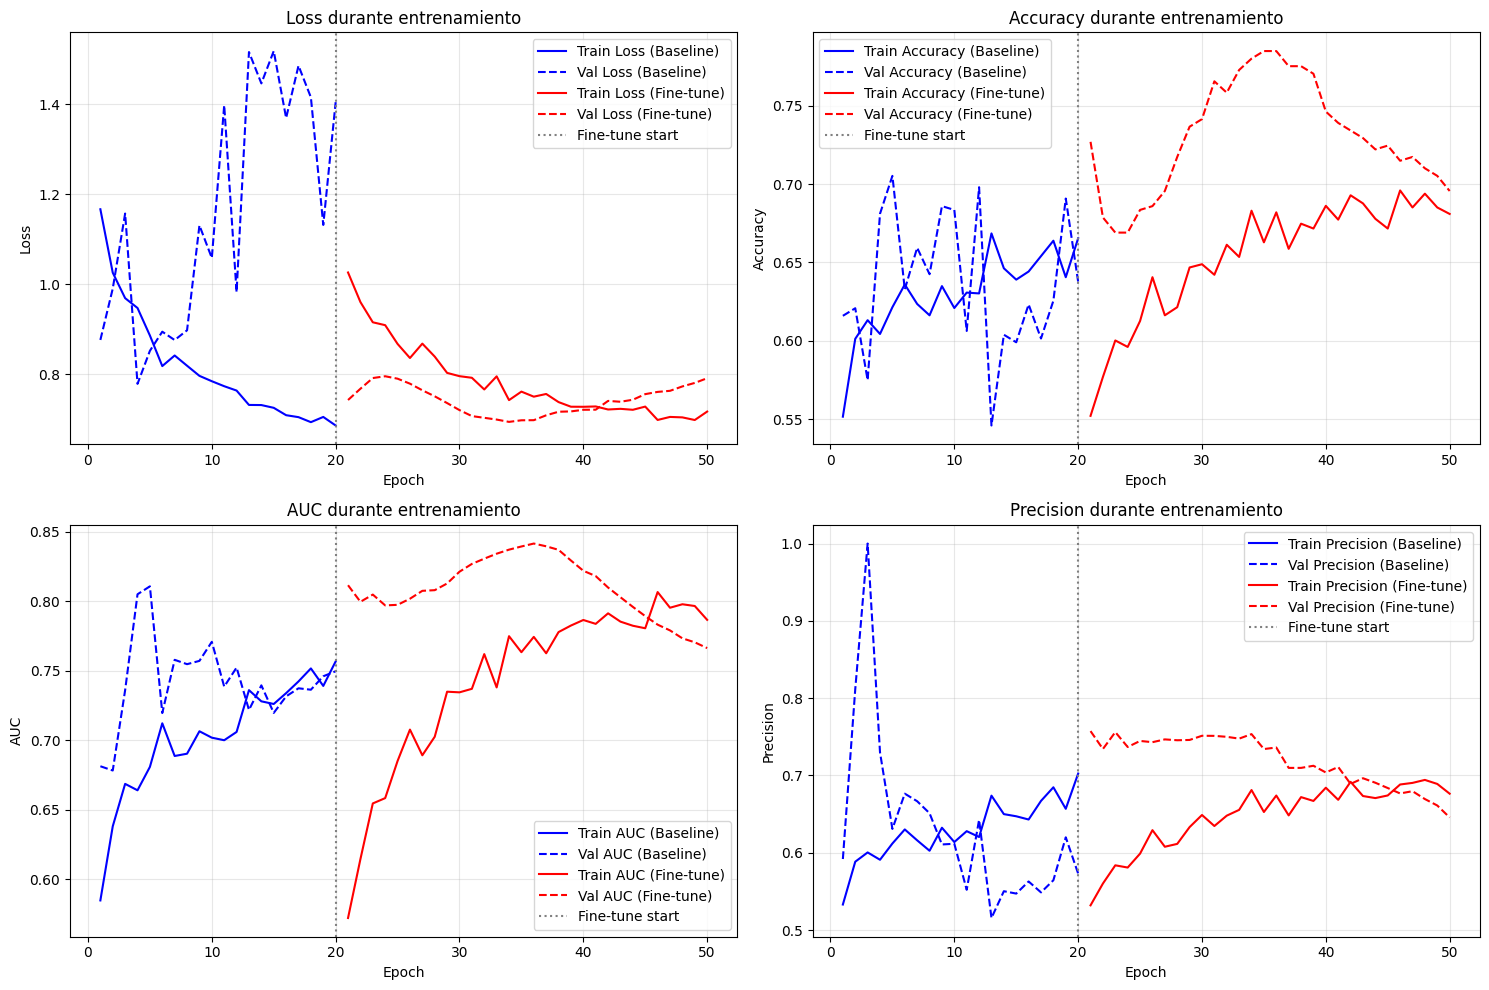

📊 Gráficas guardadas en: training_history.png


In [ ]:
# ===== ENTRENAMIENTO MEJORADO - Evita Sobreentrenamiento =====
import os, math
from pathlib import Path
import tensorflow as tf
from tensorflow.keras import regularizers

# --- Rutas del dataset final ---
BASE = Path("drive/MyDrive/UPAO/VIII/Deep Learning/Proyecto/data")
IMG = 224
BATCH = 32
AUTO = tf.data.AUTOTUNE

# --- Data loaders ---
train_ds = tf.keras.utils.image_dataset_from_directory(
    BASE/"train", image_size=(IMG, IMG), batch_size=BATCH, label_mode="binary")
val_ds = tf.keras.utils.image_dataset_from_directory(
    BASE/"val", image_size=(IMG, IMG), batch_size=BATCH, label_mode="binary")
test_ds = tf.keras.utils.image_dataset_from_directory(
    BASE/"test", image_size=(IMG, IMG), batch_size=BATCH, label_mode="binary", shuffle=False)

# Inspección de balance de clases
def count_by_label(ds):
    c0 = c1 = 0
    for x, y in ds.unbatch():
        if int(y.numpy()[0]) == 0: c0 += 1
        else: c1 += 1
    return c0, c1

c0_tr, c1_tr = count_by_label(train_ds)
print(f"[Train] atento: {c0_tr} | desatento: {c1_tr}")

# --- AUGMENTACIÓN MÁS AGRESIVA para evitar overfitting ---
data_aug = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.08),  # Más rotación
    tf.keras.layers.RandomZoom(0.15),      # Más zoom
    tf.keras.layers.RandomContrast(0.15),  # Más contraste
    tf.keras.layers.RandomBrightness(0.15), # Más brillo
    tf.keras.layers.GaussianNoise(0.02),   # Ruido gaussiano
], name="data_augmentation")

def prep(ds, train=True):
    ds = ds.shuffle(1000) if train else ds
    ds = ds.map(lambda x,y: (tf.keras.applications.mobilenet_v2.preprocess_input(x), y),
                num_parallel_calls=AUTO)
    return ds.cache().prefetch(AUTO)

train_ds_prep = prep(train_ds, train=True)
val_ds_prep   = prep(val_ds,   train=False)
test_ds_prep  = prep(test_ds,  train=False)

# --- MODELO CON REGULARIZACIÓN L2 --- TRANSFER LEARNING ---
base = tf.keras.applications.MobileNetV2(
    include_top=False, weights="imagenet", input_shape=(IMG, IMG, 3))
base.trainable = False  # Congelar inicialmente

inputs = tf.keras.Input((IMG, IMG, 3))
x = data_aug(inputs)  # Augmentation solo en training
x = base(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)  # BatchNorm después de GAP
x = tf.keras.layers.Dropout(0.4)(x)          # Dropout más alto
x = tf.keras.layers.Dense(128, activation="relu",
                          kernel_regularizer=regularizers.l2(0.001))(x)  # Regularización L2
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(inputs, outputs)

# --- CALLBACKS MEJORADOS ---
ckpt_path = "drive/MyDrive/UPAO/VIII/Deep Learning/Proyecto/modelos/atencion_mnv2_baseline_mejorado.keras"
os.makedirs(os.path.dirname(ckpt_path), exist_ok=True)

callbacks = [
    # Guardar mejor modelo basado en val_accuracy (más directo para clasificación)
    tf.keras.callbacks.ModelCheckpoint(
        ckpt_path, monitor="val_accuracy", save_best_only=True,
        mode="max", verbose=1
    ),
    # EarlyStopping ULTRA PACIENTE (solo para evitar entrenamientos infinitos)
    tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=15, restore_best_weights=True,
        mode="max", verbose=1, min_delta=0.001
    ),
    # ReduceLROnPlateau MUCHO MAS PACIENTE (reduce menos agresivamente)
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_accuracy", factor=0.3, patience=8,
        min_lr=1e-6, verbose=1, mode="max"
    )
]

# --- COMPILAR CON LEARNING RATE INICIAL MAS ALTO (aprende más rápido) ---
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),  # Volvemos a 1e-3
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(name="AUC"),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall")
    ]
)

print(" Resumen del modelo:")
model.summary()

# --- ENTRENAMIENTO BASELINE (backbone congelado) ---
print("\n FASE 1: Entrenamiento baseline (backbone congelado)")
EPOCHS_BASE = 50  # Suficientes épocas para converger
hist_base = model.fit(
    train_ds_prep,
    validation_data=val_ds_prep,
    epochs=EPOCHS_BASE,
    callbacks=callbacks,
    verbose=1
)

# --- FINE-TUNING: Descongelar últimas capas ---
print("\n FASE 2: Fine-tuning (descongelar últimas capas)")
base.trainable = True

# Congelar las primeras capas, liberar últimas 50
for layer in base.layers[:-50]:
    layer.trainable = False

# Re-compilar con LR bajo pero no demasiado
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # LR más razonable
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(name="AUC"),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall")
    ]
)

ckpt_ft_path = "drive/MyDrive/UPAO/VIII/Deep Learning/Proyecto/modelos/atencion_mnv2_finetune_mejorado.keras"
callbacks_ft = [
    tf.keras.callbacks.ModelCheckpoint(
        ckpt_ft_path, monitor="val_accuracy", save_best_only=True,
        mode="max", verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=15, restore_best_weights=True,
        mode="max", verbose=1, min_delta=0.001
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_accuracy", factor=0.3, patience=8,
        min_lr=1e-7, verbose=1, mode="max"
    )
]

EPOCHS_FT = 40  # Más épocas para fine-tuning
hist_ft = model.fit(
    train_ds_prep,
    validation_data=val_ds_prep,
    epochs=EPOCHS_FT,
    callbacks=callbacks_ft,
    verbose=1
)

# --- EVALUACIÓN COMPLETA EN TEST ---
print("\n Evaluación final en TEST:")
results = model.evaluate(test_ds_prep, verbose=1, return_dict=True)
print(f"\n Resultados en TEST:")
for metric, value in results.items():
    print(f"  {metric}: {value:.4f}")

# --- GUARDAR MODELO FINAL ---
final_path = "drive/MyDrive/UPAO/VIII/Deep Learning/Proyecto/modelos/atencion_mnv2_final_mejorado.keras"
model.save(final_path)
print(f"\n Modelo guardado en: {final_path}")

# --- VISUALIZAR HISTORIAL DE ENTRENAMIENTO ---
import matplotlib.pyplot as plt

def plot_training_history(hist_base, hist_ft):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Combinar historiales
    metrics = ['loss', 'accuracy', 'AUC', 'precision']
    titles = ['Loss', 'Accuracy', 'AUC', 'Precision']

    for idx, (metric, title) in enumerate(zip(metrics, titles)):
        ax = axes[idx // 2, idx % 2]

        # Baseline
        epochs_base = range(1, len(hist_base.history[metric]) + 1)
        ax.plot(epochs_base, hist_base.history[metric], 'b-', label=f'Train {title} (Baseline)')
        ax.plot(epochs_base, hist_base.history[f'val_{metric}'], 'b--', label=f'Val {title} (Baseline)')

        # Fine-tuning
        offset = len(epochs_base)
        epochs_ft = range(offset + 1, offset + len(hist_ft.history[metric]) + 1)
        ax.plot(epochs_ft, hist_ft.history[metric], 'r-', label=f'Train {title} (Fine-tune)')
        ax.plot(epochs_ft, hist_ft.history[f'val_{metric}'], 'r--', label=f'Val {title} (Fine-tune)')

        ax.axvline(x=offset, color='gray', linestyle=':', label='Fine-tune start')
        ax.set_xlabel('Epoch')
        ax.set_ylabel(title)
        ax.set_title(f'{title} durante entrenamiento')
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('drive/MyDrive/UPAO/VIII/Deep Learning/Proyecto/modelos/training_history.png', dpi=300)
    plt.show()
    print(" Gráficas guardadas en: training_history.png")

plot_training_history(hist_base, hist_ft)


 Análisis de overfitting y generalización

1. COMPARACIÓN DE MÉTRICAS (Train vs Val vs Test)
  Métrica  Train (sample)  Validation     Test
     Loss        0.758790    0.697768 0.791649
 Accuracy        0.747942    0.785024 0.742169
      AUC        0.792192    0.839241 0.760674
Precision        0.707865    0.734177 0.704846
   Recall        0.820312    0.870000 0.800000

 GAP Train-Val (overfitting indicator):
  Accuracy gap: 0.0371
  AUC gap: 0.0470
   GAP bajo - Buen balance, poco overfitting

2. CURVA ROC Y UMBRAL ÓPTIMO
AUC Validation: 0.8388
AUC Test: 0.7604

 Umbral óptimo (Youden): 0.5177


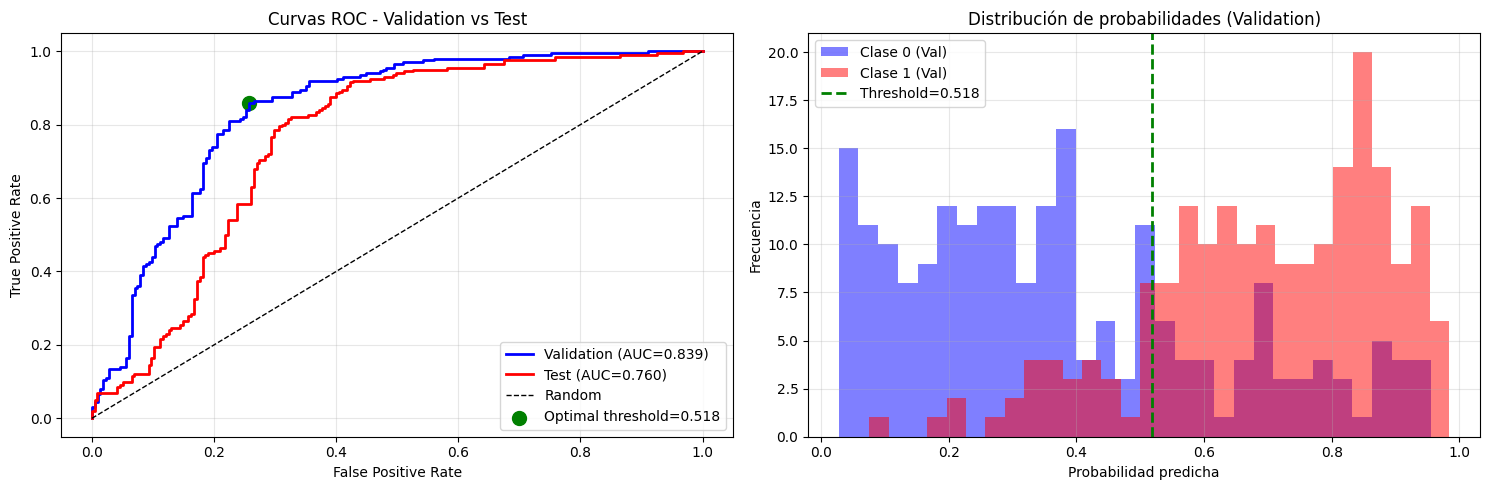


3. MATRIZ DE CONFUSIÓN Y CLASIFICACIÓN


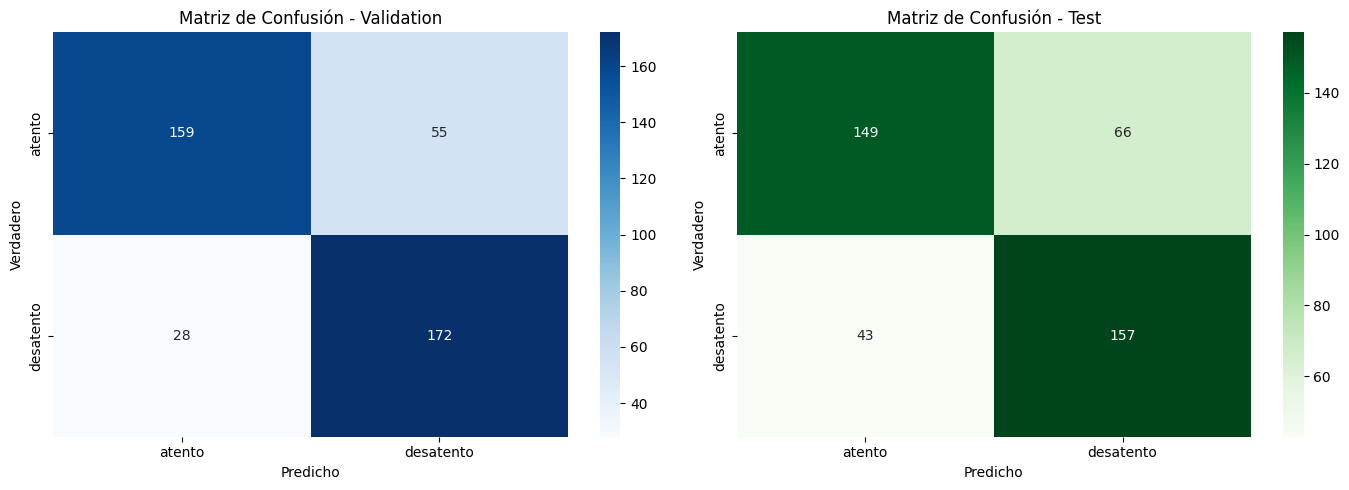


 REPORTE VALIDATION:
              precision    recall  f1-score   support

      atento     0.8503    0.7430    0.7930       214
   desatento     0.7577    0.8600    0.8056       200

    accuracy                         0.7995       414
   macro avg     0.8040    0.8015    0.7993       414
weighted avg     0.8056    0.7995    0.7991       414


 REPORTE TEST:
              precision    recall  f1-score   support

      atento     0.7760    0.6930    0.7322       215
   desatento     0.7040    0.7850    0.7423       200

    accuracy                         0.7373       415
   macro avg     0.7400    0.7390    0.7373       415
weighted avg     0.7413    0.7373    0.7371       415


4. RECOMENDACIONES

 Análisis de rendimiento:
 Overfitting bajo - El modelo generaliza bien
 Gap Test-Val significativo - Puede haber variación en datos

 Umbral recomendado para producción: 0.5177


In [ ]:
# ===== ANÁLISIS AVANZADO DE OVERFITTING =====
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

print(" Análisis de overfitting y generalización\n")

# --- 1. COMPARAR MÉTRICAS EN TRAIN vs VAL vs TEST ---
print("=" * 60)
print("1. COMPARACIÓN DE MÉTRICAS (Train vs Val vs Test)")
print("=" * 60)

# Evaluar en train (sample pequeño para rapidez)
train_sample = train_ds_prep.take(50)
train_results = model.evaluate(train_sample, verbose=0, return_dict=True)

# Evaluar en val
val_results = model.evaluate(val_ds_prep, verbose=0, return_dict=True)

# Evaluar en test
test_results = model.evaluate(test_ds_prep, verbose=0, return_dict=True)

# Crear tabla comparativa
metrics_comparison = {
    'Métrica': ['Loss', 'Accuracy', 'AUC', 'Precision', 'Recall'],
    'Train (sample)': [
        train_results['loss'],
        train_results['accuracy'],
        train_results['AUC'],
        train_results['precision'],
        train_results['recall']
    ],
    'Validation': [
        val_results['loss'],
        val_results['accuracy'],
        val_results['AUC'],
        val_results['precision'],
        val_results['recall']
    ],
    'Test': [
        test_results['loss'],
        test_results['accuracy'],
        test_results['AUC'],
        test_results['precision'],
        test_results['recall']
    ]
}

import pandas as pd
df_metrics = pd.DataFrame(metrics_comparison)
print(df_metrics.to_string(index=False))

# Calcular gaps de overfitting
print(f"\n GAP Train-Val (overfitting indicator):")
print(f"  Accuracy gap: {abs(train_results['accuracy'] - val_results['accuracy']):.4f}")
print(f"  AUC gap: {abs(train_results['AUC'] - val_results['AUC']):.4f}")
if abs(train_results['accuracy'] - val_results['accuracy']) < 0.05:
    print("   GAP bajo - Buen balance, poco overfitting")
elif abs(train_results['accuracy'] - val_results['accuracy']) < 0.10:
    print("   GAP moderado - Algo de overfitting")
else:
    print("   GAP alto - Overfitting significativo")

# --- 2. CURVA ROC Y UMBRAL ÓPTIMO ---
print("\n" + "=" * 60)
print("2. CURVA ROC Y UMBRAL ÓPTIMO")
print("=" * 60)

# Obtener probabilidades en VAL
y_val = []
y_val_prob = []
for xb, yb in val_ds_prep:
    y_val.append(yb.numpy().ravel())
    y_val_prob.append(model.predict(xb, verbose=0).ravel())
y_val = np.concatenate(y_val)
y_val_prob = np.concatenate(y_val_prob)

# Obtener probabilidades en TEST
y_test = []
y_test_prob = []
for xb, yb in test_ds_prep:
    y_test.append(yb.numpy().ravel())
    y_test_prob.append(model.predict(xb, verbose=0).ravel())
y_test = np.concatenate(y_test)
y_test_prob = np.concatenate(y_test_prob)

# Calcular AUC
val_auc = roc_auc_score(y_val, y_val_prob)
test_auc = roc_auc_score(y_test, y_test_prob)
print(f"AUC Validation: {val_auc:.4f}")
print(f"AUC Test: {test_auc:.4f}")

# Curvas ROC
fpr_val, tpr_val, thr_val = roc_curve(y_val, y_val_prob)
fpr_test, tpr_test, thr_test = roc_curve(y_test, y_test_prob)

# Umbral óptimo (Youden's J statistic)
youden = tpr_val - fpr_val
best_idx = np.argmax(youden)
best_threshold = thr_val[best_idx]
print(f"\n Umbral óptimo (Youden): {best_threshold:.4f}")

# Plot ROC curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# ROC Curves
ax1.plot(fpr_val, tpr_val, 'b-', label=f'Validation (AUC={val_auc:.3f})', linewidth=2)
ax1.plot(fpr_test, tpr_test, 'r-', label=f'Test (AUC={test_auc:.3f})', linewidth=2)
ax1.plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1)
ax1.scatter(fpr_val[best_idx], tpr_val[best_idx], s=100, c='green',
           marker='o', label=f'Optimal threshold={best_threshold:.3f}')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Curvas ROC - Validation vs Test')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Distribución de probabilidades
ax2.hist(y_val_prob[y_val == 0], bins=30, alpha=0.5, label='Clase 0 (Val)', color='blue')
ax2.hist(y_val_prob[y_val == 1], bins=30, alpha=0.5, label='Clase 1 (Val)', color='red')
ax2.axvline(best_threshold, color='green', linestyle='--', linewidth=2, label=f'Threshold={best_threshold:.3f}')
ax2.set_xlabel('Probabilidad predicha')
ax2.set_ylabel('Frecuencia')
ax2.set_title('Distribución de probabilidades (Validation)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('drive/MyDrive/UPAO/VIII/Deep Learning/Proyecto/modelos/roc_analysis.png', dpi=300)
plt.show()

# --- 3. MATRIZ DE CONFUSIÓN Y REPORTE DETALLADO ---
print("\n" + "=" * 60)
print("3. MATRIZ DE CONFUSIÓN Y CLASIFICACIÓN")
print("=" * 60)

# Predicciones con umbral óptimo
y_pred_val = (y_val_prob >= best_threshold).astype(int)
y_pred_test = (y_test_prob >= best_threshold).astype(int)

# Matrices de confusión
cm_val = confusion_matrix(y_val, y_pred_val)
cm_test = confusion_matrix(y_test, y_pred_test)

# Plot matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Validation
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['atento', 'desatento'],
            yticklabels=['atento', 'desatento'])
ax1.set_title('Matriz de Confusión - Validation')
ax1.set_ylabel('Verdadero')
ax1.set_xlabel('Predicho')

# Test
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens', ax=ax2,
            xticklabels=['atento', 'desatento'],
            yticklabels=['atento', 'desatento'])
ax2.set_title('Matriz de Confusión - Test')
ax2.set_ylabel('Verdadero')
ax2.set_xlabel('Predicho')

plt.tight_layout()
plt.savefig('drive/MyDrive/UPAO/VIII/Deep Learning/Proyecto/modelos/confusion_matrices.png', dpi=300)
plt.show()

# Reportes de clasificación
print("\n REPORTE VALIDATION:")
print(classification_report(y_val, y_pred_val, target_names=['atento', 'desatento'], digits=4))

print("\n REPORTE TEST:")
print(classification_report(y_test, y_pred_test, target_names=['atento', 'desatento'], digits=4))

# --- 4. RECOMENDACIONES ---
print("\n" + "=" * 60)
print("4. RECOMENDACIONES")
print("=" * 60)

gap_acc = abs(train_results['accuracy'] - val_results['accuracy'])
gap_test_val = abs(test_results['accuracy'] - val_results['accuracy'])

print("\n Análisis de rendimiento:")
if gap_acc < 0.05:
    print(" Overfitting bajo - El modelo generaliza bien")
elif gap_acc < 0.10:
    print(" Overfitting moderado - Considera:")
    print("   • Aumentar dropout (actual: 0.4 y 0.3)")
    print("   • Aumentar regularización L2")
    print("   • Más data augmentation")
else:
    print(" Overfitting alto - Acciones recomendadas:")
    print("   • Aumentar dropout a 0.5-0.6")
    print("   • Incrementar L2 regularization")
    print("   • Reducir capas entrenables en fine-tuning")
    print("   • Agregar más datos de entrenamiento")

if gap_test_val < 0.03:
    print(" Test-Val consistency buena - Modelo estable")
else:
    print(" Gap Test-Val significativo - Puede haber variación en datos")

print(f"\n Umbral recomendado para producción: {best_threshold:.4f}")


In [ ]:
# ===== GUARDAR CONFIGURACIÓN ÓPTIMA Y ARCHIVO PARA PRODUCCIÓN =====
import json

# Guardar configuración del modelo y umbral óptimo
config = {
    "model_path": "drive/MyDrive/UPAO/VIII/Deep Learning/Proyecto/modelos/atencion_mnv2_final_mejorado.keras",
    "optimal_threshold": float(best_threshold),
    "input_size": [IMG, IMG],
    "preprocessing": "mobilenet_v2",
    "metrics": {
        "test_accuracy": float(test_results['accuracy']),
        "test_auc": float(test_results['AUC']),
        "test_precision": float(test_results['precision']),
        "test_recall": float(test_results['recall']),
        "test_loss": float(test_results['loss'])
    },
    "class_names": {
        "0": "atento",
        "1": "desatento"
    },
    "training_info": {
        "backbone": "MobileNetV2",
        "pretrained": "ImageNet",
        "trainable_layers": 50,
        "dropout": [0.4, 0.3],
        "l2_regularization": 0.001,
        "augmentation": [
            "RandomFlip(horizontal)",
            "RandomRotation(0.08)",
            "RandomZoom(0.15)",
            "RandomContrast(0.15)",
            "RandomBrightness(0.15)",
            "GaussianNoise(0.02)"
        ],
        "epochs_baseline": EPOCHS_BASE,
        "epochs_finetune": EPOCHS_FT
    }
}

config_path = "drive/MyDrive/UPAO/VIII/Deep Learning/Proyecto/modelos/model_config.json"
with open(config_path, 'w') as f:
    json.dump(config, f, indent=2)

print(" Configuración guardada en:", config_path)
print(f"\n Configuración del modelo:")
print(json.dumps(config, indent=2))

# --- CREAR VERSIÓN PARA PRODUCCIÓN (TensorFlow Lite - opcional) ---
print("\n ¿Deseas convertir el modelo a TensorFlow Lite para mejor rendimiento?")
print("   (Recomendado para deployment en producción y mayor FPS)")

# Descomentar las siguientes líneas para generar TFLite
"""
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

tflite_path = "drive/MyDrive/UPAO/VIII/Deep Learning/Proyecto/modelos/atencion_mnv2_final.tflite"
with open(tflite_path, 'wb') as f:
    f.write(tflite_model)
print(f" Modelo TFLite guardado en: {tflite_path}")

# Comparar tamaños
import os
keras_size = os.path.getsize(final_path) / (1024 * 1024)
tflite_size = os.path.getsize(tflite_path) / (1024 * 1024)
print(f"\n Comparación de tamaños:")
print(f"   Keras (.keras): {keras_size:.2f} MB")
print(f"   TFLite (.tflite): {tflite_size:.2f} MB")
print(f"   Reducción: {((keras_size - tflite_size) / keras_size * 100):.1f}%")
"""

print("\n" + "=" * 70)
print(" ENTRENAMIENTO COMPLETO - RESUMEN FINAL")
print("=" * 70)
print(f" Modelo baseline: atencion_mnv2_baseline_mejorado.keras")
print(f" Modelo fine-tuned: atencion_mnv2_finetune_mejorado.keras")
print(f" Modelo final: atencion_mnv2_final_mejorado.keras")
print(f" Configuración: model_config.json")
print(f" Gráficas: training_history.png, roc_analysis.png, confusion_matrices.png")
print(f"\n Umbral óptimo para app.py: {best_threshold:.4f}")
print(f" Test Accuracy: {test_results['accuracy']:.4f}")
print(f" Test AUC: {test_results['AUC']:.4f}")
print(f"\n Siguiente paso: Usa este modelo en tu app.py con el umbral {best_threshold:.4f}")
print("=" * 70)


 Configuración guardada en: drive/MyDrive/UPAO/VIII/Deep Learning/Proyecto/modelos/model_config.json

 Configuración del modelo:
{
  "model_path": "drive/MyDrive/UPAO/VIII/Deep Learning/Proyecto/modelos/atencion_mnv2_final_mejorado.keras",
  "optimal_threshold": 0.5177164077758789,
  "input_size": [
    224,
    224
  ],
  "preprocessing": "mobilenet_v2",
  "metrics": {
    "test_accuracy": 0.742168664932251,
    "test_auc": 0.7606743574142456,
    "test_precision": 0.7048457860946655,
    "test_recall": 0.800000011920929,
    "test_loss": 0.7916491627693176
  },
  "class_names": {
    "0": "atento",
    "1": "desatento"
  },
  "training_info": {
    "backbone": "MobileNetV2",
    "pretrained": "ImageNet",
    "trainable_layers": 50,
    "dropout": [
      0.4,
      0.3
    ],
    "l2_regularization": 0.001,
    "augmentation": [
      "RandomFlip(horizontal)",
      "RandomRotation(0.08)",
      "RandomZoom(0.15)",
      "RandomContrast(0.15)",
      "RandomBrightness(0.15)",
      "